# Plota série temporal da precipitação diária do MERGE para um determinado município
 - Dados MERGE diário fornecido pelo CPTEC: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/
 - Realizado por: Enrique V. Mattos - 28/08/2025

# **1° Passo:** Preparando ambiente

In [ ]:
# instalações
!pip install -q ultraplot cartopy pygrib pyproj geopandas rioxarray geobr salem folium

# monta o drive
from google.colab import drive
drive.mount('/content/drive')

# nome do diretório
dir = '/content/drive/MyDrive/2-PESQUISA/0_GLM/estudos_de_caso/2025-08-22-FRENTEFRIA_RS'

# importa bibliotecas
import ultraplot as uplt
import xarray as xr
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import os
import glob
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import time
from matplotlib import cm
import matplotlib.patches as patches
import pygrib
import matplotlib
import rioxarray as rxr
from datetime import datetime, timedelta
import pandas as pd
import geobr
import salem

import warnings
warnings.filterwarnings("ignore")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.0/338.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.1/86.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.6 MB/s eta 0:00:00
Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/ultraplot/__init__.py:77: UltraPlotWarning: Rebuilding font cache. This usually happens after installing or updating ultraplot.
  register_fonts(default=True)


# **2° Passo:** Declarando funções

In [ ]:
# shapefile: Município
def carrega_shape_municipio(municipio):

    municipios_geobr = geobr.read_municipality(code_muni="all", year=2020)

    municipio_geobr = municipios_geobr [municipios_geobr['name_muni'] == municipio]

    if municipios_geobr.empty:
        raise ValueError(f"Não encontrado o estado '{estado}'.")
    municipio_geobr.crs = 'epsg:4674'

    return municipio_geobr

# **Processando os dados**

## Baixando os dados
Para baixar os dados de 1/jan/2025 até 24/ago/2025 demora 6min 55s.

In [ ]:
%%time
# ano, mes e dia INICIAL do período
anoi = 2025
mesi = 1
diai = 1

# ano, mes e dia FINAL do período
anof = 2025
mesf = 8
diaf = 24

# FTP dos dados por dia
ftp = 'http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/'

# Data desejada
date_in = datetime(anoi, mesi, diai)
date_ini = date_in.strftime('%Y%m%d')

date_en = datetime(anof, mesf, diaf)
date_end = date_en.strftime('%Y%m%d')

# Número de dias
n_days = date_en - date_in

# Download dos dados
for file in pd.date_range(date_ini, date_end, freq='d'):

    # extrai ano e mes
    ano = file.strftime('%Y')
    mes = file.strftime('%m')
    dia = file.strftime('%d')

    # nome do arquivo
    filename = f'MERGE_CPTEC_{ano}{mes}{dia}.grib2'

    # ftp + filename. Exemplo: http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2023/09/MERGE_CPTEC_20230920.grib2
    ftp_filename = f'{ftp}{ano}/{mes.zfill(2)}/{filename}'

    # baixando arquivo diário de chuva
    !wget {ftp_filename}

    print('\n---------------------')
    print('Downloading FTP File:')
    print('---------------------')
    print('Model: MERGE')
    print('File Name: ' + ftp_filename)

--2025-08-28 19:46:56--  http://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/01/MERGE_CPTEC_20250101.grib2
Resolving ftp.cptec.inpe.br (ftp.cptec.inpe.br)... 150.163.178.56
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/01/MERGE_CPTEC_20250101.grib2 [following]
--2025-08-28 19:46:57--  https://ftp.cptec.inpe.br/modelos/tempo/MERGE/GPM/DAILY/2025/01/MERGE_CPTEC_20250101.grib2
Connecting to ftp.cptec.inpe.br (ftp.cptec.inpe.br)|150.163.178.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410276 (401K)
Saving to: ‘MERGE_CPTEC_20250101.grib2’

MERGE_CPTEC_2025010 100%[===================>] 400.66K   468KB/s    in 0.9s    

2025-08-28 19:46:59 (468 KB/s) - ‘MERGE_CPTEC_20250101.grib2’ saved [410276/410276]


---------------------
---------------------
Model: MERGE
File Name: http://ftp.c

## Processando os dados

Leitura dos dados. Demora 2min 58s.

In [ ]:
%%time
#==========================================================================#
#                           PARÂMETROS GERAIS                              #
#==========================================================================#
# Seleciona a área
lonmin = -78.0
lonmax = -30.0
latmin = -40.0
latmax =  12.0

# Selecina a extensão da imagem [min. lon, min. lat, max. lon, max. lat]
extent = [lonmin, latmin, lonmax, latmax]

#==========================================================================#
#                           CARREGA SHAPEFILE
#==========================================================================#
# define o município/estado e carrega shapefile
ESTADO = 'RS'
MUNICIPIO = 'Canguçu'
NAME = f'{MUNICIPIO}/{ESTADO}'
shapefile_regiao_cangucu = carrega_shape_municipio(MUNICIPIO)

ESTADO = 'RS'
MUNICIPIO = 'São Gabriel'
NAME = f'{MUNICIPIO}/{ESTADO}'
shapefile_regiao_saogabriel = carrega_shape_municipio(MUNICIPIO)

#==========================================================================#
#                           LOOP DOS ARQUIVOS
#==========================================================================#
# declaração das listas
chuva_cangucu, chuva_saogabriel, ano_mes_dia = [], [], []

# Loop nos arquivos diários
for file in pd.date_range(date_ini, date_end, freq='d'):

    # Extrai no formato '2021-10-17 00:00:00' para '20211017'
    dia = file.strftime('%Y%m%d')

    # Monta o nome do arquivo 'MERGE_CPTEC_20211001.grib2'
    file_name = f'MERGE_CPTEC_{str(dia)}.grib2'

    # Monta o caminho e nome do arquivo '/content/input/MERGE_CPTEC_20211017.grib2'
    grib = f'/content/{file_name}'

    # Se o arquivo existe
    if (os.path.exists(grib)):

        # Lendo o arquivo
        grib = pygrib.open(grib)

        # Lendo o campo do modelo
        grb = grib.select(name='Precipitation')[0]

        # Extrai os dados para uma área específica
        precip, lats, lons = grb.data(lat1=extent[1],lat2=extent[3],lon1=extent[0]+360,lon2=extent[2]+360)

        # Transforma a matriz para Xarray.DataSet
        data_vars = {'daily_rain':(('lat', 'lon'), precip, {'units': 'mm', 'long_name':'Precipitação'})}
        coords = {'lat': lats[:, 0], 'lon': lons[0,:]}
        ds = xr.Dataset(data_vars=data_vars, coords=coords)

        # Transforma longitude de 0 à 360 para 0 à +-180 graus
        ds.coords['lon'] = ((ds.coords['lon'] + 180) % 360) - 180 ; ds = ds.sortby(ds.lon)

        # CANGUÇU: aplica a máscara no dataset e extrai o valor máximo de chuva dentro da região
        merge_regiao_cangucu = ds.salem.roi(shape=shapefile_regiao_cangucu)
        chuva_max_regiao_cangucu = merge_regiao_cangucu.max(dim=["lat", "lon"])

        # SÃO GABRIEL: aplica a máscara no dataset e extrai o valor máximo de chuva dentro da região
        merge_regiao_saogabriel = ds.salem.roi(shape=shapefile_regiao_saogabriel)
        chuva_max_regiao_saogabriel = merge_regiao_saogabriel.max(dim=["lat", "lon"])

        # appenda os valores de chuva e a data
        chuva_cangucu.append(float(chuva_max_regiao_cangucu['daily_rain']))
        chuva_saogabriel.append(float(chuva_max_regiao_saogabriel['daily_rain']))
        ano_mes_dia.append(file.strftime('%Y-%m-%d'))

        # imprimindo na tela o arquivo atual
        print('Processando ---->>>> Data:', file.strftime('%Y-%m-%d'), '/' ,
              'Chuva_Canguçu=', float(chuva_max_regiao_cangucu['daily_rain']), ' ',
              'Chuva_São_Gabriel=', float(chuva_max_regiao_saogabriel['daily_rain']))

#==========================================================================#
#                      COLOCA OS DADOS NUM DATAFRAME
#==========================================================================#
ts_diaria = pd.DataFrame({'data': ano_mes_dia,
                          'chuva_cangucu': chuva_cangucu,
                          'chuva_saogabriel': chuva_saogabriel})
ts_diaria['data'] = pd.to_datetime(ts_diaria['data'])
ts_diaria.set_index('data', inplace=True)

In [ ]:
shapefile_regiao_cangucu

,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
4684,4304507.0,Canguçu,43.0,RS,Rio Grande do Sul,4.0,Sul,"MULTIPOLYGON (((-52.25582 -30.88441, -52.24935..."


In [ ]:
shapefile_regiao_saogabriel

,code_muni,name_muni,code_state,abbrev_state,name_state,code_region,name_region,geometry
2184,2929255.0,São Gabriel,29.0,BA,Bahia,2.0,Nordeste,"MULTIPOLYGON (((-41.66276 -10.8112, -41.65738 ..."
4991,4318309.0,São Gabriel,43.0,RS,Rio Grande do Sul,4.0,Sul,"MULTIPOLYGON (((-54.235 -29.90374, -54.22827 -..."


In [ ]:
ds

<xarray.Dataset> Size: 2MB
Dimensions:     (lat: 520, lon: 480)
Coordinates:
  * lat         (lat) float64 4kB -39.95 -39.85 -39.75 ... 11.75 11.85 11.95
  * lon         (lon) float64 4kB -77.95 -77.85 -77.75 ... -30.25 -30.15 -30.05
Data variables:
    daily_rain  (lat, lon) float64 2MB 1.125 1.75 1.75 1.75 ... 3.5 2.75 1.0

In [ ]:
merge_regiao_cangucu

<xarray.Dataset> Size: 2MB
Dimensions:     (lat: 520, lon: 480)
Coordinates:
  * lat         (lat) float64 4kB -39.95 -39.85 -39.75 ... 11.75 11.85 11.95
  * lon         (lon) float64 4kB -77.95 -77.85 -77.75 ... -30.25 -30.15 -30.05
Data variables:
    daily_rain  (lat, lon) float64 2MB nan nan nan nan nan ... nan nan nan nan
Attributes:
    pyproj_srs:  +proj=longlat +datum=WGS84 +no_defs

In [ ]:
merge_regiao_cangucu['daily_rain'].max()

<xarray.DataArray 'daily_rain' ()> Size: 8B
array(4.875)

In [ ]:
chuva_max_regiao_cangucu

<xarray.Dataset> Size: 8B
Dimensions:     ()
Data variables:
    daily_rain  float64 8B 4.875

In [ ]:
ts_diaria

,chuva_cangucu,chuva_saogabriel
data,,
2025-01-01,0.0000,16.6250
2025-01-02,29.5000,0.0625
2025-01-03,1.3125,0.0000
2025-01-04,0.1250,0.0000
2025-01-05,0.0000,0.0000
...,...,...
2025-08-20,17.1250,29.3750
2025-08-21,2.1250,0.8750
2025-08-22,56.6250,58.3750


In [ ]:
# encontra o índice do dataframe respectivo do dia 23/08/2025
dia_x = '2025-08-23'
indice = ts_diaria.index.get_loc('2025-08-23')
indice

234

# **Plota figura - CANGUÇU**

In [ ]:
# mostras os dados que usaremos
ts_diaria

,chuva_cangucu,chuva_saogabriel
data,,
2025-01-01,0.0000,16.6250
2025-01-02,29.5000,0.0625
2025-01-03,1.3125,0.0000
2025-01-04,0.1250,0.0000
2025-01-05,0.0000,0.0000
...,...,...
2025-08-20,17.1250,29.3750
2025-08-21,2.1250,0.8750
2025-08-22,56.6250,58.3750


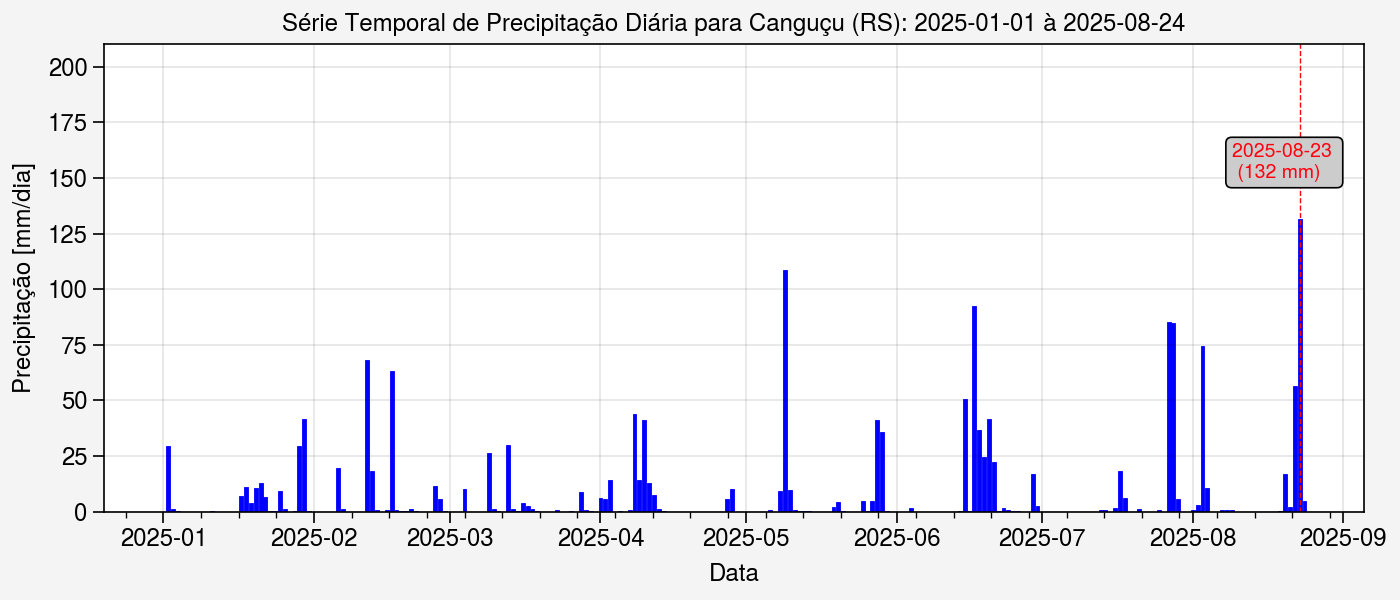

In [ ]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(7, 3), tight=True)

# plota gráfico de barras
# ts_diaria.index.strftime('%Y-%m-%d')
ax.bar(ts_diaria['chuva_cangucu'].index,
       ts_diaria['chuva_cangucu'],
       color='blue')

# chuva do dia 23 de agosto de 2025
chuva_dia23 = round(ts_diaria.loc[dia_x]['chuva_cangucu'])

# linha vertical indicando o dia 23/ago/2025
ax.axvline(x=ts_diaria.index[indice], color='bright red', linestyle='--', lw=0.5)

# anotação da linha vertical
ax.annotate(f"{dia_x} \n ({chuva_dia23} mm)", xy=(ts_diaria.index[220], 150), fontsize=7, color='bright red',
             bbox=dict(boxstyle="round", fc="0.8"))

# formato dos eixos
ax.format(title='Série Temporal de Precipitação Diária para Canguçu (RS): 2025-01-01 à 2025-08-24',
          xlabel='Data',
          ylabel='Precipitação [mm/dia]',
          small='12px',
          large='12px',
          xrotation=0,
          ytickminor=False,
          ylim=(0, 210))

# salva figura
fig.save(f'{dir}/output/merge/serie_temporal_merge_cangucu_RS.jpg', dpi=300)

# exibe figura na tela
uplt.show()

# **Plota figura - SÃO GABRIEL**

In [ ]:
# mostras os dados que usaremos
ts_diaria

,chuva_cangucu,chuva_saogabriel
data,,
2025-01-01,0.0000,16.6250
2025-01-02,29.5000,0.0625
2025-01-03,1.3125,0.0000
2025-01-04,0.1250,0.0000
2025-01-05,0.0000,0.0000
...,...,...
2025-08-20,17.1250,29.3750
2025-08-21,2.1250,0.8750
2025-08-22,56.6250,58.3750


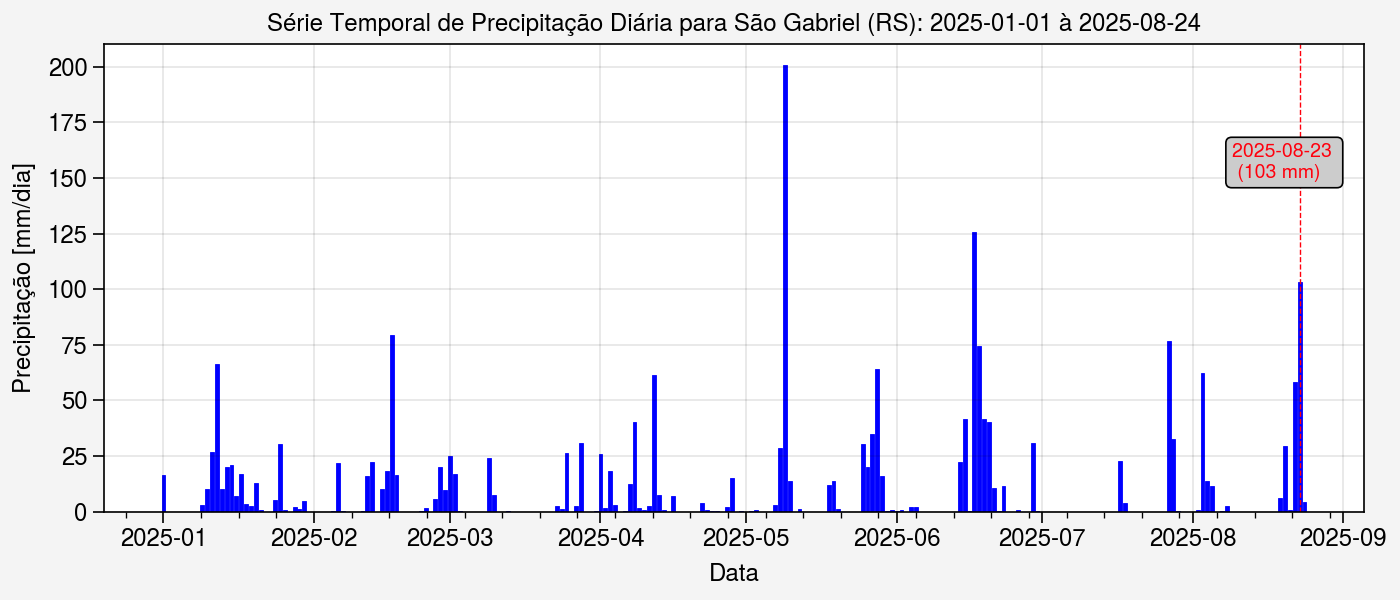

In [ ]:
# cria a moldura da figura
fig, ax = uplt.subplots(figsize=(7, 3), tight=True)

# plota gráfico de barras
ax.bar(ts_diaria['chuva_saogabriel'].index,
       ts_diaria['chuva_saogabriel'],
       color='blue')

# chuva do dia 23 de agosto de 2025
chuva_dia23 = round(ts_diaria.loc[dia_x]['chuva_saogabriel'])

# linha vertical indicando o dia 23/ago/2025
ax.axvline(x=ts_diaria.index[indice], color='bright red', linestyle='--', lw=0.5)

# anotação da linha vertical
ax.annotate(f"{dia_x} \n ({chuva_dia23} mm)", xy=(ts_diaria.index[220], 150), fontsize=7, color='bright red',
             bbox=dict(boxstyle="round", fc="0.8"))

# formato dos eixos
ax.format(title='Série Temporal de Precipitação Diária para São Gabriel (RS): 2025-01-01 à 2025-08-24',
          xlabel='Data',
          ylabel='Precipitação [mm/dia]',
          small='12px',
          large='12px',
          xrotation=0,
          ytickminor=False,
          ylim=(0, 210))

# salva figura
fig.save(f'{dir}/output/merge/serie_temporal_merge_saogabriel_RS.jpg', dpi=300)

# exibe figura na tela
uplt.show()